<a href="https://colab.research.google.com/github/Mayank17M/Movie-Recommender/blob/main/Movie_Recommendation(Content_fitering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Recommendation system**
**Name**: Mayank Mamgain

**Uni. Roll No**: 2013655




*Authenticating my google account with google colab as I'm working on google colab.*

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### **Getting datasets from my google drive.**




In [ ]:
downloaded = drive.CreateFile({'id':'1WdoPXdf2mXVJPuHbDWUGC-Iu_sov3sAO'}) 
downloaded.GetContentFile('movies_metadata.csv') 

In [ ]:
downloaded = drive.CreateFile({'id':'1b5Cpom61J2b0tM57hvoxNIGfGjmN6uQB'}) 
downloaded.GetContentFile('links_small.csv') 

In [ ]:
downloaded = drive.CreateFile({'id':'121_IBnM0fSUmAdw1RZK1vrq2jaAbhenk'}) 
downloaded.GetContentFile('credits.csv') 

In [ ]:
downloaded = drive.CreateFile({'id':'1v6dwemNWyhVoE36su3Jml3FpgO8435LI'}) 
downloaded.GetContentFile('keywords.csv') 

# **Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import warnings; warnings.simplefilter('ignore')

# **Importing and studying type of data in our dataset**

In [ ]:
md = pd.read_csv('movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


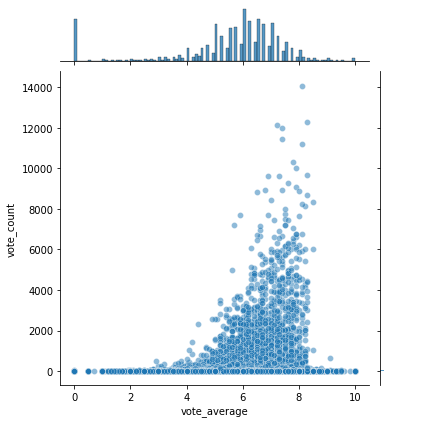

In [ ]:
sns.jointplot(data=md,x='vote_average',y='vote_count',alpha=0.5)

*Here we can see we have a large number of movies having zero ratings, so we will get rid of them before making our recommender.*

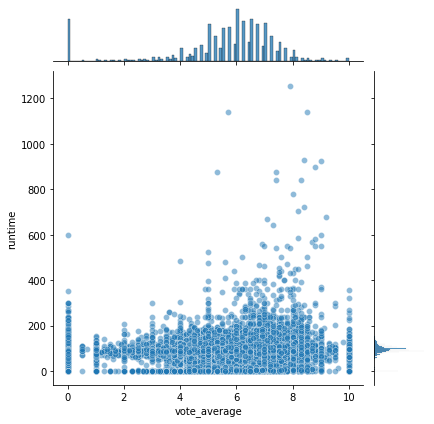

In [ ]:
sns.jointplot(data=md,x='vote_average',y='runtime',alpha=0.5)

*We can see that the runtime does not have a huge impact on ratings of the movies.*

## **1. Simple Recommender**

The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list.

In [ ]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

I use the TMDB Ratings to come up with our Top Movies Chart.
I used IMDB's weighted rating formula to construct my chart.

Weighted Rating (WR) =  [(v/(v+m).R]+[(m/(v+m).C] 

*v = number of votes for the movie*

*m = minimum votes required to be listed in the chart*

*R = average rating of the movie*

*C = mean vote across the whole report*

In [ ]:
#checking for any null values
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

*I will use 95th percentile as our cutoff to determine value of m beecause a large number of movies have 0 or very low number of ratings. So, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.*

In [ ]:
m = vote_counts.quantile(0.95)
m

434.0

*Therefore, to qualify to be considered for the chart, a movie has to have at least 434 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10.*

**Pre-processing data**

In [ ]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [ ]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

**Top Movies**

In [ ]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


In [ ]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


# **2. Content Based Recommender**

The recommender we built in the previous is not very effective and have several limtations. It gives the same recommendation to everyone, regardless of the user's personal taste. 

To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked.

I will build two Content Based Recommenders based on:

**Movie Overviews and Taglines**

**Movie Cast, Crew, Keywords and Genre** 

In [ ]:
#importing another dataset
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int') 

In [ ]:
md = md.drop([19730, 29503, 35587])

In [ ]:
md['id'] = md['id'].astype('int')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

## **2.1 Movie Description Based Recommender** 


So I will first try to build a recommender using movie descriptions and taglines. We do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively.



*The **tagline** and **overview** in our dataset contains the information and description about the movie so we will merge them in one column **description** and remove the spaces.*

In [ ]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

*The goal of using **tf-idf** is to scale down the impact of tokens that occur very frequently in a given body which is our **description** in this case.*

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [ ]:
tfidf_matrix.shape

(9099, 268124)

### **Cosine Similarity**

*I will use the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:*

cosine(x,y)= (x.y)/(||x||.||y||)

*Since I have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.* 

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
print(cosine_sim)

[[1.         0.02441931 0.02738955 ... 0.         0.         0.        ]
 [0.02441931 1.         0.         ... 0.02973505 0.02500782 0.        ]
 [0.02738955 0.         1.         ... 0.03335187 0.         0.        ]
 ...
 [0.         0.02973505 0.03335187 ... 1.         0.08700222 0.        ]
 [0.         0.02500782 0.         ... 0.08700222 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


*We now have a **pairwise cosine similarity** matrix for all the movies in our dataset. The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.*

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

*Finally using all that pre-processed data and cosine-similarity to make a function that will actually give us our recommendations.*

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

In [ ]:
get_recommendations('The Godfather').head(15)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
618                     Thinner
3609              Harlem Nights
8816              Run All Night
3288          Jaws: The Revenge
2192           The Color Purple
Name: title, dtype: object

In [ ]:
get_recommendations('Toy Story').head(10)

2502               Toy Story 2
7535               Toy Story 3
6193    The 40 Year Old Virgin
2547           Man on the Moon
6627              Factory Girl
4702    What's Up, Tiger Lily?
889      Rebel Without a Cause
6554    For Your Consideration
4988          Rivers and Tides
1599                 Condorman
Name: title, dtype: object

## **2.2 Metadata Based Recommender**

To build our standard metadata based content recommender, we will need to merge our current dataset with the **crew** and the **keyword** datasets.

In [ ]:
#importing the datasets
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

**Merging datasets**

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [ ]:
md.shape

(45463, 25)

In [ ]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

**Crew:** *From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.*

**Cast:** *Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.*

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

**literal_eval** : *Its is a function in python to safely evaluate an expression node or a Unicode or Latin-1 encoded string containing a Python expression.*

In [ ]:
#getting the names of the directors
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)


In [ ]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

I will create a metadata dump for every movie which consists of **genres, director, main actors and keywords**. I then use a **Count Vectorizer** to create our count matrix as we did in the Description Recommender. Then we calculate the cosine similarities and return movies that are most similar.

***Strip Spaces and Convert to Lowercase*** from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

*Mention Director 3 times to give it more weight relative to the entire cast.*

In [ ]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

**Keywords**

*I did a small amount of pre-processing of the keywords before putting them to any use. As a first step, I calculate the frequency counts of every keyword that appears in the dataset.*

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [ ]:
#removing keywords that appear only once
s = s[s > 1] 

In [ ]:
#converting every word to its stem
stemmer = SnowballStemmer('english')
stemmer.stem('balls')

'ball'

In [ ]:
#filtering the keywords
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))



**CountVectorizer** can lowercase letters, disregard punctuation and stopwords.

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
#again using cosine similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.02441931 0.02738955 ... 0.         0.         0.        ]
 [0.02441931 1.         0.         ... 0.02973505 0.02500782 0.        ]
 [0.02738955 0.         1.         ... 0.03335187 0.         0.        ]
 ...
 [0.         0.02973505 0.03335187 ... 1.         0.08700222 0.        ]
 [0.         0.02500782 0.         ... 0.08700222 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

*We will reuse the **get_recommendations** function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results.*

In [ ]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

In [ ]:
get_recommendations('The Godfather').head(15)

3616    Tucker: The Man and His Dream
994            The Godfather: Part II
1346                    The Rainmaker
3705                  The Cotton Club
4518               One from the Heart
3300                 Gardens of Stone
1602          The Godfather: Part III
2998                 The Conversation
5867                      Rumble Fish
1992            Peggy Sue Got Married
1691                    The Outsiders
642                              Jack
981                    Apocalypse Now
1100                          Dracula
4148                      The Gambler
Name: title, dtype: object